In [3]:
# Initial setup:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1

#For fancy plots
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

import numpy as np

from scipy.stats import multivariate_normal, gamma
from scipy.linalg import sqrtm

import getdist
from getdist import plots, MCSamples
getdist.chains.print_load_details = False

from scipy.stats import gamma
from scipy.special import erfcinv


import git, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
path_global = os.path.dirname(path_git)
print('Path to git repo: {}'.format(path_global))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Path to git repo: /home/matias/Documents/PhD/code


# Three moltivariate distributions

In [4]:
#Fixed Parameters
#num_parameters = 2
#num_datasets = 3

#Sharp triangle
mean_A = np.array([-1/2., 0.]) 
mean_B = np.array([1/2, 0.])
mean_C = np.array([0, np.sqrt(3)/2.])

cov_A = np.array([[1, 0.], [0., 1]])
cov_B = cov_A.copy()
cov_C = cov_A.copy()

In [5]:
#Define some functions:

def calculate_R_CM(vectors):
    num_vectors = len(vectors)
    R_CM = np.sum(vectors, axis=0) / num_vectors
    return R_CM

def construct_C(vectors):
    L = len(vectors)

    R_CM = calculate_R_CM(vectors)

    K_xx = np.sum((vectors[:, 0] - R_CM[0]) ** 2)
    K_yy = np.sum((vectors[:, 1] - R_CM[1]) ** 2)
    K_xy = np.sum((vectors[:, 0] - R_CM[0]) * (vectors[:, 1] - R_CM[1]))
    K_yx = K_xy
    C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/(L-1)
    #C = np.array([[K_xx, K_xy], [K_yx,K_yy]])/L
    return C



For conviencience we will name the pairs as:

* 1: AB
* 2: AC
* 3: BC

## Tension vectors
$$\vec{r}_{1}=\frac{1}{\sqrt{C_{A}+C_{B}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{B}) $$
$$\vec{r}_{2}=\frac{1}{\sqrt{C_{A}+C_{C}}}(\vec{\bar{\theta}}_{A}-\vec{\bar{\theta}}_{C}) $$
$$\vec{r}_{3}=\frac{1}{\sqrt{C_{B}+C_{C}}}(\vec{\bar{\theta}}_{B}-\vec{\bar{\theta}}_{C}) $$

In general, if we have N datasets, the total number tension vectors is 

$$L=\frac{N^2-N}{2}=\frac{N(N-1)}{2}$$

## Center of Mass

$$\vec{R}_{CM} = \frac{\sum_i m_{i} \vec{r}_{i}}{\sum_i m_{i}} \, ,$$

where $m_{i}=1$.

## Mass Dispertion Tensor

$$K_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} (\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})$$

$$\mathcal{C}_{ij} = \frac{K_{ij}}{\sum_i m_{i}} \, ,$$

## Inertia Tensor

$$I_{ij} = \sum_{k=\{1, 2, 3\}} m_{k} [\delta_{ij}|\vec{r}_{k}-\vec{R}_{CM}|^{2}-(\vec{r}^{i}_{k}-\vec{R}^{i}_{CM}) (\vec{r}^{j}_{k}-\vec{R}^{j}_{CM})]$$



Plot this information:

# Real data

In [6]:
import git
import sys, os

# Create the two toy chains and the joint chain:
path_git = git.Repo('.', search_parent_directories=True).working_tree_dir
#os.chdir(os.path.join(path_git, 'source'))

os.chdir(os.path.join(path_global,'montepython_public_old','output'))   
#os.chdir('/home/matias/Documents/PhD/code/montepython_public_old/output')

#Fixed Parameters
#num_parameters = 2
#num_datasets = 4

'''
A: CC 
B: Planck18 
C: BAO 
D: PPS
'''

chain_A = getdist.mcsamples.loadMCSamples(file_root='lcdm_cc/2023-09-18_1000000_', no_cache=True,settings={'loglikes':True,'label':'CC','ignore_rows': '0.3'})
chain_B = getdist.mcsamples .loadMCSamples(file_root='lcdm_planck/2023-09-16_1000000_', no_cache=True,settings={'loglikes':True,'label':'Planck18','ignore_rows': '0.3'})
chain_C = getdist.mcsamples.loadMCSamples(file_root='lcdm_bao_plus/2024-03-07_1000000_', no_cache=True,settings={'label':'BAO','ignore_rows': '0.3'})
chain_D = getdist.mcsamples.loadMCSamples(file_root='lcdm_pps/2023-09-18_1000000_', no_cache=True,settings={'label':'PPS','ignore_rows': '0.3'})



param_names = ['Omega_m','H0'] #Shared paameters
names = param_names
labels = names

#Estimate the mean and covariance of the chains:
mean_A = chain_A.mean(param_names)
cov_A = chain_A.cov(param_names)
mean_B = chain_B.mean(param_names)
cov_B = chain_B.cov(param_names)
mean_C = chain_C.mean(param_names)
cov_C = chain_C.cov(param_names)
mean_D = chain_D.mean(param_names)
cov_D = chain_D.cov(param_names)


In [7]:
os.path.join(path_git, 'notebooks','PRL', 'figures')
print(path_git)

/home/matias/Documents/PhD/code/multimeter


Center of mass: [-1.1227663  -1.84922768]
Tensor of Inertia: [[1.9538412  2.15803215]
 [2.15803215 5.42756901]]
Eigenvalues: [0.92054284 6.46086737]
Eigenvectors: [[-0.90193956 -0.43186227]
 [ 0.43186227 -0.90193956]]


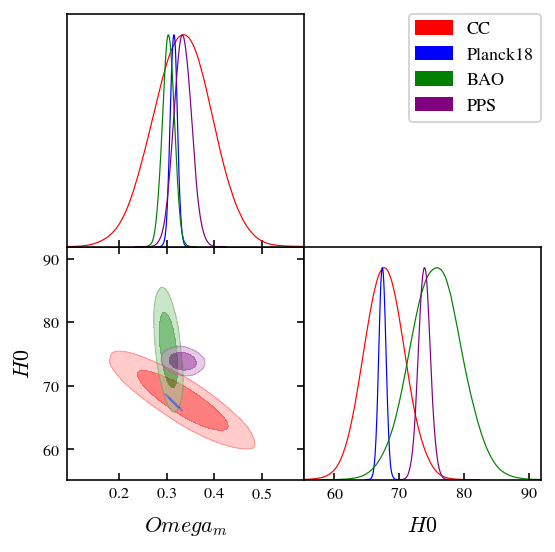

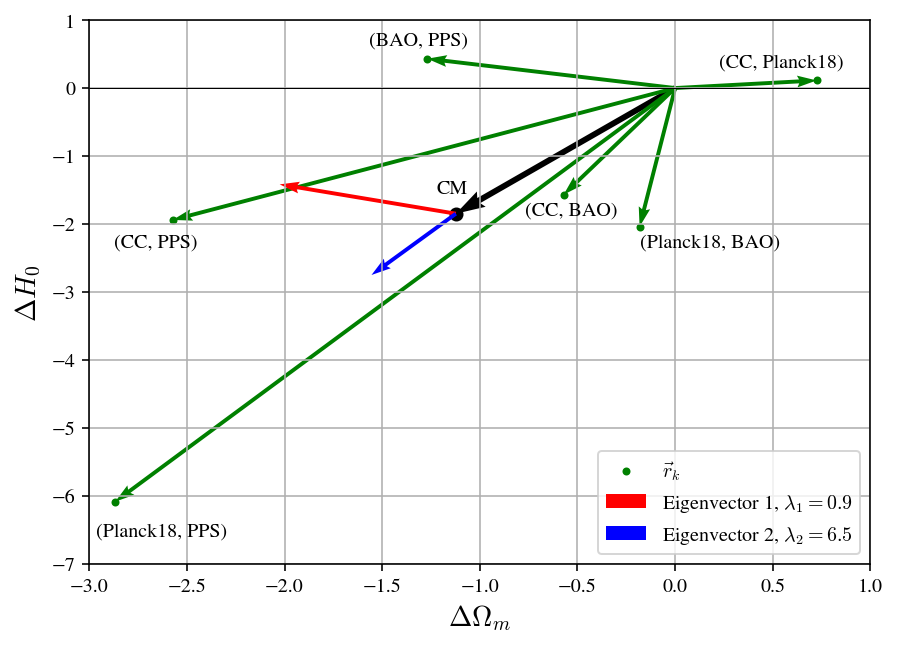

In [8]:
# Plot the distribution of the center of mass   
r_1 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_B)), (mean_A - mean_B))
r_2 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_C)), (mean_A - mean_C))
r_3 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_C)), (mean_B - mean_C))
r_4 = np.dot(sqrtm(np.linalg.inv(cov_A + cov_D)), (mean_A - mean_D))
r_5 = np.dot(sqrtm(np.linalg.inv(cov_B + cov_D)), (mean_B - mean_D))
r_6 = np.dot(sqrtm(np.linalg.inv(cov_C + cov_D)), (mean_C - mean_D))


# Example usage:
vectors = np.array([r_1, r_2, r_3, r_4, r_5, r_6])
R_CM = calculate_R_CM(vectors)
print('Center of mass: {}'.format(R_CM))

# Example usage:
C = construct_C(vectors)
print('Tensor of Inertia: {}'.format(C))
eigenvalues, eigenvectors = np.linalg.eig(C)
print('Eigenvalues: {}'.format(eigenvalues))
print('Eigenvectors: {}'.format(eigenvectors))

samps_A = np.random.multivariate_normal(mean_A, cov_A, size=10000)
samps_B = np.random.multivariate_normal(mean_B, cov_B, size=10000)
samps_C = np.random.multivariate_normal(mean_C, cov_C, size=10000)
samps_D = np.random.multivariate_normal(mean_D, cov_D, size=10000)

chain_A = MCSamples(samples=samps_A, names=names, labels=labels, label='Dataset A')
chain_B = MCSamples(samples=samps_B, names=names, labels=labels, label='Dataset B')
chain_C = MCSamples(samples=samps_C, names=names, labels=labels, label='Dataset C')
chain_D = MCSamples(samples=samps_D, names=names, labels=labels, label='Dataset D')

colors = ['red', 'blue', 'green', 'purple']

g = plots.get_subplot_plotter()
g.triangle_plot([chain_A, chain_B, chain_C, chain_D],\
                filled=True, contour_args={'alpha':0.5},\
                contour_colors=colors,
                legend_labels=['CC', 'Planck18', 'BAO', 'PPS'])
os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
g.export('dist_data.pdf')

fig, ax = plt.subplots(1,1, figsize=(7,5))
samps_Rcm= multivariate_normal(R_CM, C)
ax.quiver(0, 0, R_CM[0], R_CM[1], angles='xy', scale_units='xy', scale=1, color='k')
ax.quiver(0, 0, r_1[0], r_1[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_2[0], r_2[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_3[0], r_3[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_4[0], r_4[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_5[0], r_5[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)
ax.quiver(0, 0, r_6[0], r_6[1], angles='xy', scale_units='xy', scale=1, color='g', width=0.005,)

ax.scatter([r_1[0], r_2[0], r_3[0], r_4[0], r_5[0], r_6[0]], [r_1[1], r_2[1], r_3[1], r_4[1], r_5[1], r_6[1]], marker='.',color='green', label=r'$\vec{r}_{k}$')
ax.scatter([R_CM[0]], [R_CM[1]], color='black')#, label='CM')

ax.text(R_CM[0]-0.1, R_CM[1]+0.3, 'CM')
ax.text(r_1[0]-0.5, r_1[1]+0.2, '(CC, Planck18)', size=10)
ax.text(r_2[0]-0.2, r_2[1]-0.3, '(CC, BAO)')
ax.text(r_3[0]-0.0, r_3[1]-0.3, '(Planck18, BAO)')
ax.text(r_4[0]-0.3, r_4[1]-0.4, '(CC, PPS)')
ax.text(r_5[0]-0.1, r_5[1]-0.5, '(Planck18, PPS)')
ax.text(r_6[0]-0.3, r_6[1]+0.2, '(BAO, PPS)')

ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 0], eigenvectors[1, 0], angles='xy', scale_units='xy', scale=1, color='r', width=0.005,label=r'Eigenvector 1, $\lambda_1={:.1f}$'.format(eigenvalues[0]))
ax.quiver(R_CM[0], R_CM[1], eigenvectors[0, 1], eigenvectors[1, 1], angles='xy', scale_units='xy', scale=1, color='b', width=0.005,label=r'Eigenvector 2, $\lambda_2={:.1f}$'.format(eigenvalues[1]))

ax.set_xlim(-3, 1)
ax.set_ylim(-7, 1)
ax.set_xlabel(r'$\Delta \Omega_m$',size=14)

ax.hlines(0, -3, 1, color='black', lw=0.5)
ax.set_ylabel(r'$\Delta H_0$',size=14)
ax.grid()
ax.legend(loc='lower right')


'''
A: CC 
B: Planck18 
C: BAO 
D: PPS

1:AB
2:AC
3:BC
4:AD
5:BD
6:CD
'''

os.chdir(os.path.join(path_git, 'notebooks','PRL', 'figures'))
fig.savefig('tension_data_2.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [9]:
#def Q_tot(diff_mean_1, diff_mean_2, diff_mean_3, cov_1, cov_2, cov_3, n_samples, L):

D=2
L=6
n_samples = int(1e6)

def Q_tot(mean_A, mean_B, mean_C, mean_D, cov_A, cov_B, cov_C, cov_D, n_samples, L, H0=False):
    cov_1 = cov_A + cov_B
    cov_2 = cov_A + cov_C
    cov_3 = cov_B + cov_C
    cov_4 = cov_A + cov_D
    cov_5 = cov_B + cov_D
    cov_6 = cov_C + cov_D


    DA = np.random.multivariate_normal(mean_A, cov_A, size=n_samples)
    DB = np.random.multivariate_normal(mean_B, cov_B, size=n_samples)
    DC = np.random.multivariate_normal(mean_C, cov_C, size=n_samples)
    DD = np.random.multivariate_normal(mean_D, cov_D, size=n_samples)
    

    # Sampling
    sample_1 = np.dot(sqrtm(np.linalg.inv(cov_1)), np.array(DA-DB).T)  # Shape: (d, n_samples)
    sample_2 = np.dot(sqrtm(np.linalg.inv(cov_2)), np.array(DA-DC).T)  # Shape: (d, n_samples)
    sample_3 = np.dot(sqrtm(np.linalg.inv(cov_3)), np.array(DB-DC).T)  # Shape: (d, n_samples)
    sample_4 = np.dot(sqrtm(np.linalg.inv(cov_4)), np.array(DA-DD).T)  # Shape: (d, n_samples)
    sample_5 = np.dot(sqrtm(np.linalg.inv(cov_5)), np.array(DB-DD).T)  # Shape: (d, n_samples)
    sample_6 = np.dot(sqrtm(np.linalg.inv(cov_6)), np.array(DC-DD).T)  # Shape: (d, n_samples)

    if H0==True:
        r_tot = (sample_1 - np.mean(sample_1, axis=1, keepdims=True)) + \
                (sample_2 - np.mean(sample_2, axis=1, keepdims=True)) + \
                (sample_3 - np.mean(sample_3, axis=1, keepdims=True)) + \
                (sample_4 - np.mean(sample_4, axis=1, keepdims=True)) + \
                (sample_5 - np.mean(sample_5, axis=1, keepdims=True)) + \
                (sample_6 - np.mean(sample_6, axis=1, keepdims=True))
                
    else:
        r_tot = sample_1 + sample_2 + sample_3 + sample_4 + sample_5 + sample_6
    Q = np.zeros(n_samples)  # Initialize W
    for i in range(n_samples):
        Q[i] = np.dot(r_tot[:, i], r_tot[:, i])  # Shape: (n_samples,)

    return Q / L**2

D=2
L=6
samples_size = int(1e6)


#Under H0

t=np.linspace(0, 1.1*np.linalg.norm(R_CM)**2, 100)
theoretical_dist = gamma.pdf(t,a=D/2, scale=2/L)

Q_0 = Q_tot(mean_A, mean_B, mean_C, mean_D, cov_A, cov_B, cov_C, cov_D, samples_size, L, H0=True)
Q_1 = Q_tot(mean_A, mean_B, mean_C, mean_D, cov_A, cov_B, cov_C, cov_D, samples_size, L, H0=False)

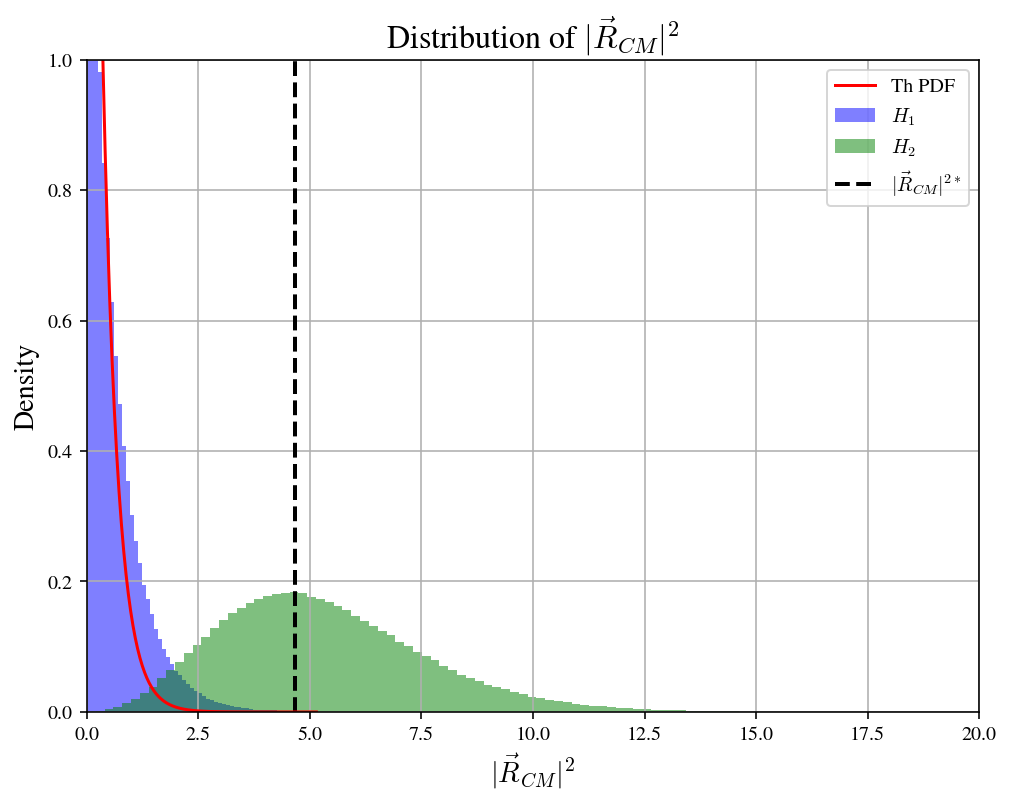

In [10]:

#Under H0
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(t, theoretical_dist, color='red', label='Th PDF')
ax.hist(Q_0, bins=100, density=True, alpha=0.5, color='blue', label=r'$H_1$')
ax.hist(Q_1, bins=100, density=True, alpha=0.5, color='green', label=r'$H_2$')
ax.vlines(R_CM[0]**2 + R_CM[1]**2, 0, 4, linestyles='dashed',color='black', lw=2, label=r'$|\vec{R}_{CM}|^{2*}$')
ax.legend()
ax.set_xlabel(r'$|\vec{R}_{CM}|^2$', size=14)
ax.set_ylabel('Density', size=14)
ax.set_title(r'Distribution of $|\vec{R}_{CM}|^2$', size=16)
ax.set_xlim(0, 20)
ax.set_ylim(0, 1)
ax.grid()

In [11]:
N_sigma = np.zeros(10000)
# Calculate N_sigma for each sample in sample_dist_H1
#for i in range(len(sample_dist_H1)):
for i in range(len(N_sigma)):
    Q = Q_1[i]
    PTE = np.sum(Q_0[Q_0 >= Q])/ len(Q_0)
    N_sigma[i] = np.sqrt(2)*erfcinv(PTE)

In [12]:
# Integrate from np.linalg.norm(R_CM)**2 to infinity
PTE = np.sum(Q_0[Q_0 >= np.linalg.norm(R_CM)**2])/ len(Q_0)
n_sigma = np.sqrt(2)*erfcinv(PTE)
print(f'n_sigma = {n_sigma:.2f}')

n_sigma = 2.86


In [13]:
N_sigma_1 = N_sigma[N_sigma > 0]
N_sigma_2 = N_sigma_1[np.isfinite(N_sigma_1)]

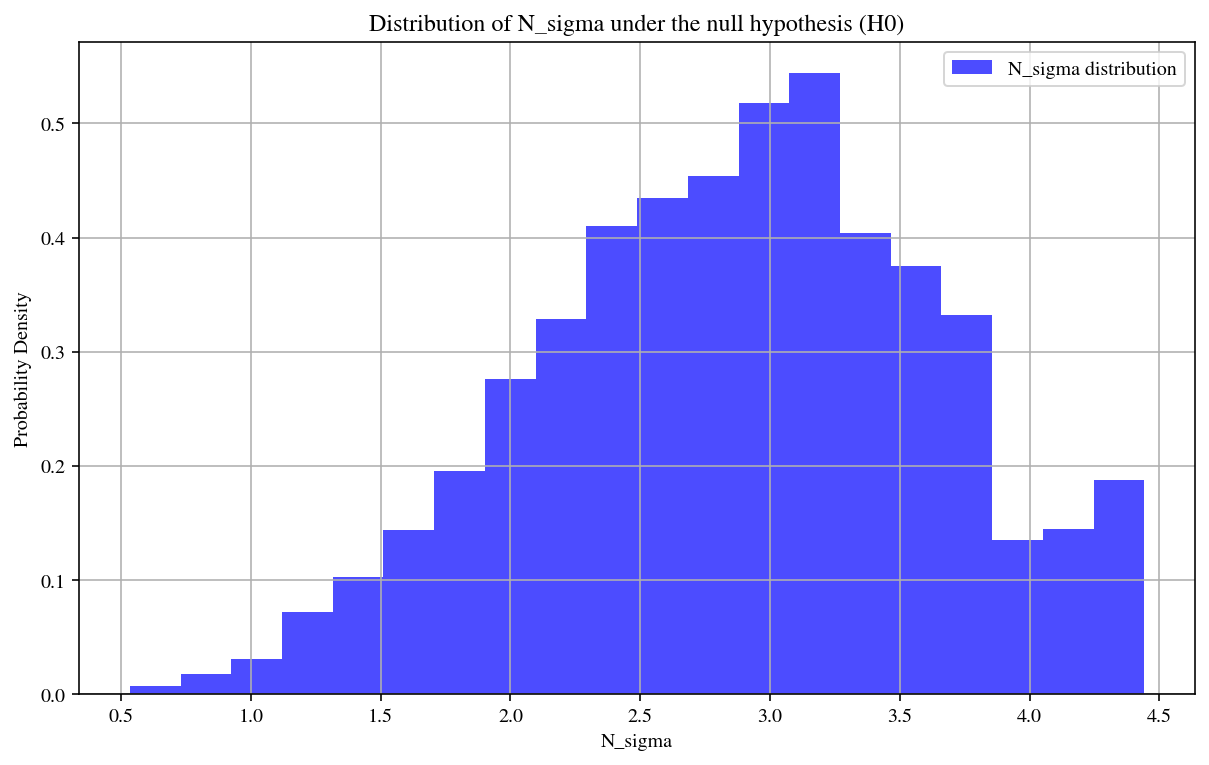

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(N_sigma_2, bins=20, density=True, alpha=0.7, color='blue', label='N_sigma distribution')
#ax.axvline(n_sigma, color='red', linestyle='--', label=f'n_sigma = {n_sigma:.2f}')
ax.set_xlabel('N_sigma')
ax.set_ylabel('Probability Density')
ax.set_title('Distribution of N_sigma under the null hypothesis (H0)')
ax.grid(True)
ax.legend()
plt.show()

In [16]:
print(np.mean(Q_0), D/L)

0.6204174487389509 0.3333333333333333
